In [369]:
# Import required libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Import decision tree from tree module
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Import random forest classifier from ensemble module
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Using metrics module for accuracy calculation 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [370]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [371]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [372]:
# You can also drop whichever other columns you'd like here
# Columns PassengerId, Name and Ticket shouldn"t be related to the survival probability.
titanic_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

# Handle Age column missing value with median age 
median_age = titanic_df["Age"].median()
titanic_df["Age"].fillna(median_age, inplace=True)

# Embarked column only 2 missing values, so fill with mode
mode_embarked = titanic_df["Embarked"].mode()[0]
titanic_df["Embarked"].fillna(mode_embarked, inplace=True)

# Get the number of missing data points per column
missing_values_count = titanic_df.isnull().sum()
print(missing_values_count)


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [373]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Machine Learning classifiers don"t know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

### Label Encoding

In [374]:
# Label Encode Sex and Embarked
label_encoder = LabelEncoder()
titanic_df['Sex'] = label_encoder.fit_transform(titanic_df['Sex'])
titanic_df['Embarked'] = label_encoder.fit_transform(titanic_df['Embarked'])
titanic_df.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         2
1         1       1    0  38.0      1      0  71.2833         0
2         1       3    0  26.0      0      0   7.9250         2
3         1       1    0  35.0      1      0  53.1000         2
4         0       3    1  35.0      0      0   8.0500         2

### Split the data into a training, development, and test set.

In [375]:
# Different features and target
X_features = titanic_df.drop("Survived", axis=1)
y_target = titanic_df["Survived"]

rseed = 23
# split the original dataset into train and test + dev sets, I want test and dev set are same shape data. 70 : 15 :15
X_train , X_dev_test, y_train, y_dev_test = train_test_split(X_features, y_target, test_size=0.3, random_state=rseed)

# split the training set further into training and development sets.
X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5, random_state=rseed)

# Print train, devlopment, test data shapes
print("Train data:", X_train.shape, y_train.shape)
print("Development data:", X_dev.shape, y_dev.shape)
print("Test data:", X_test.shape, y_test.shape)

Train data: (623, 7) (623,)
Development data: (134, 7) (134,)
Test data: (134, 7) (134,)


### Train a decision tree and make a plot of it

In [376]:
# Training a model without pruning
tianic_model_unsimple = DecisionTreeClassifier(max_depth=None, random_state=rseed)
tianic_model_unsimple.fit(X_train, y_train)

# Predict the response for development dataset
y_train_pred = tianic_model_unsimple.predict(X_train)
y_dev_pred = tianic_model_unsimple.predict(X_dev)

# Show accuracy score 
print("Performance without pruning:", tianic_model_unsimple.score(X_dev, y_dev))
print("At depth:", tianic_model_unsimple.tree_.max_depth)

Performance without pruning: 0.7985074626865671
At depth: 18


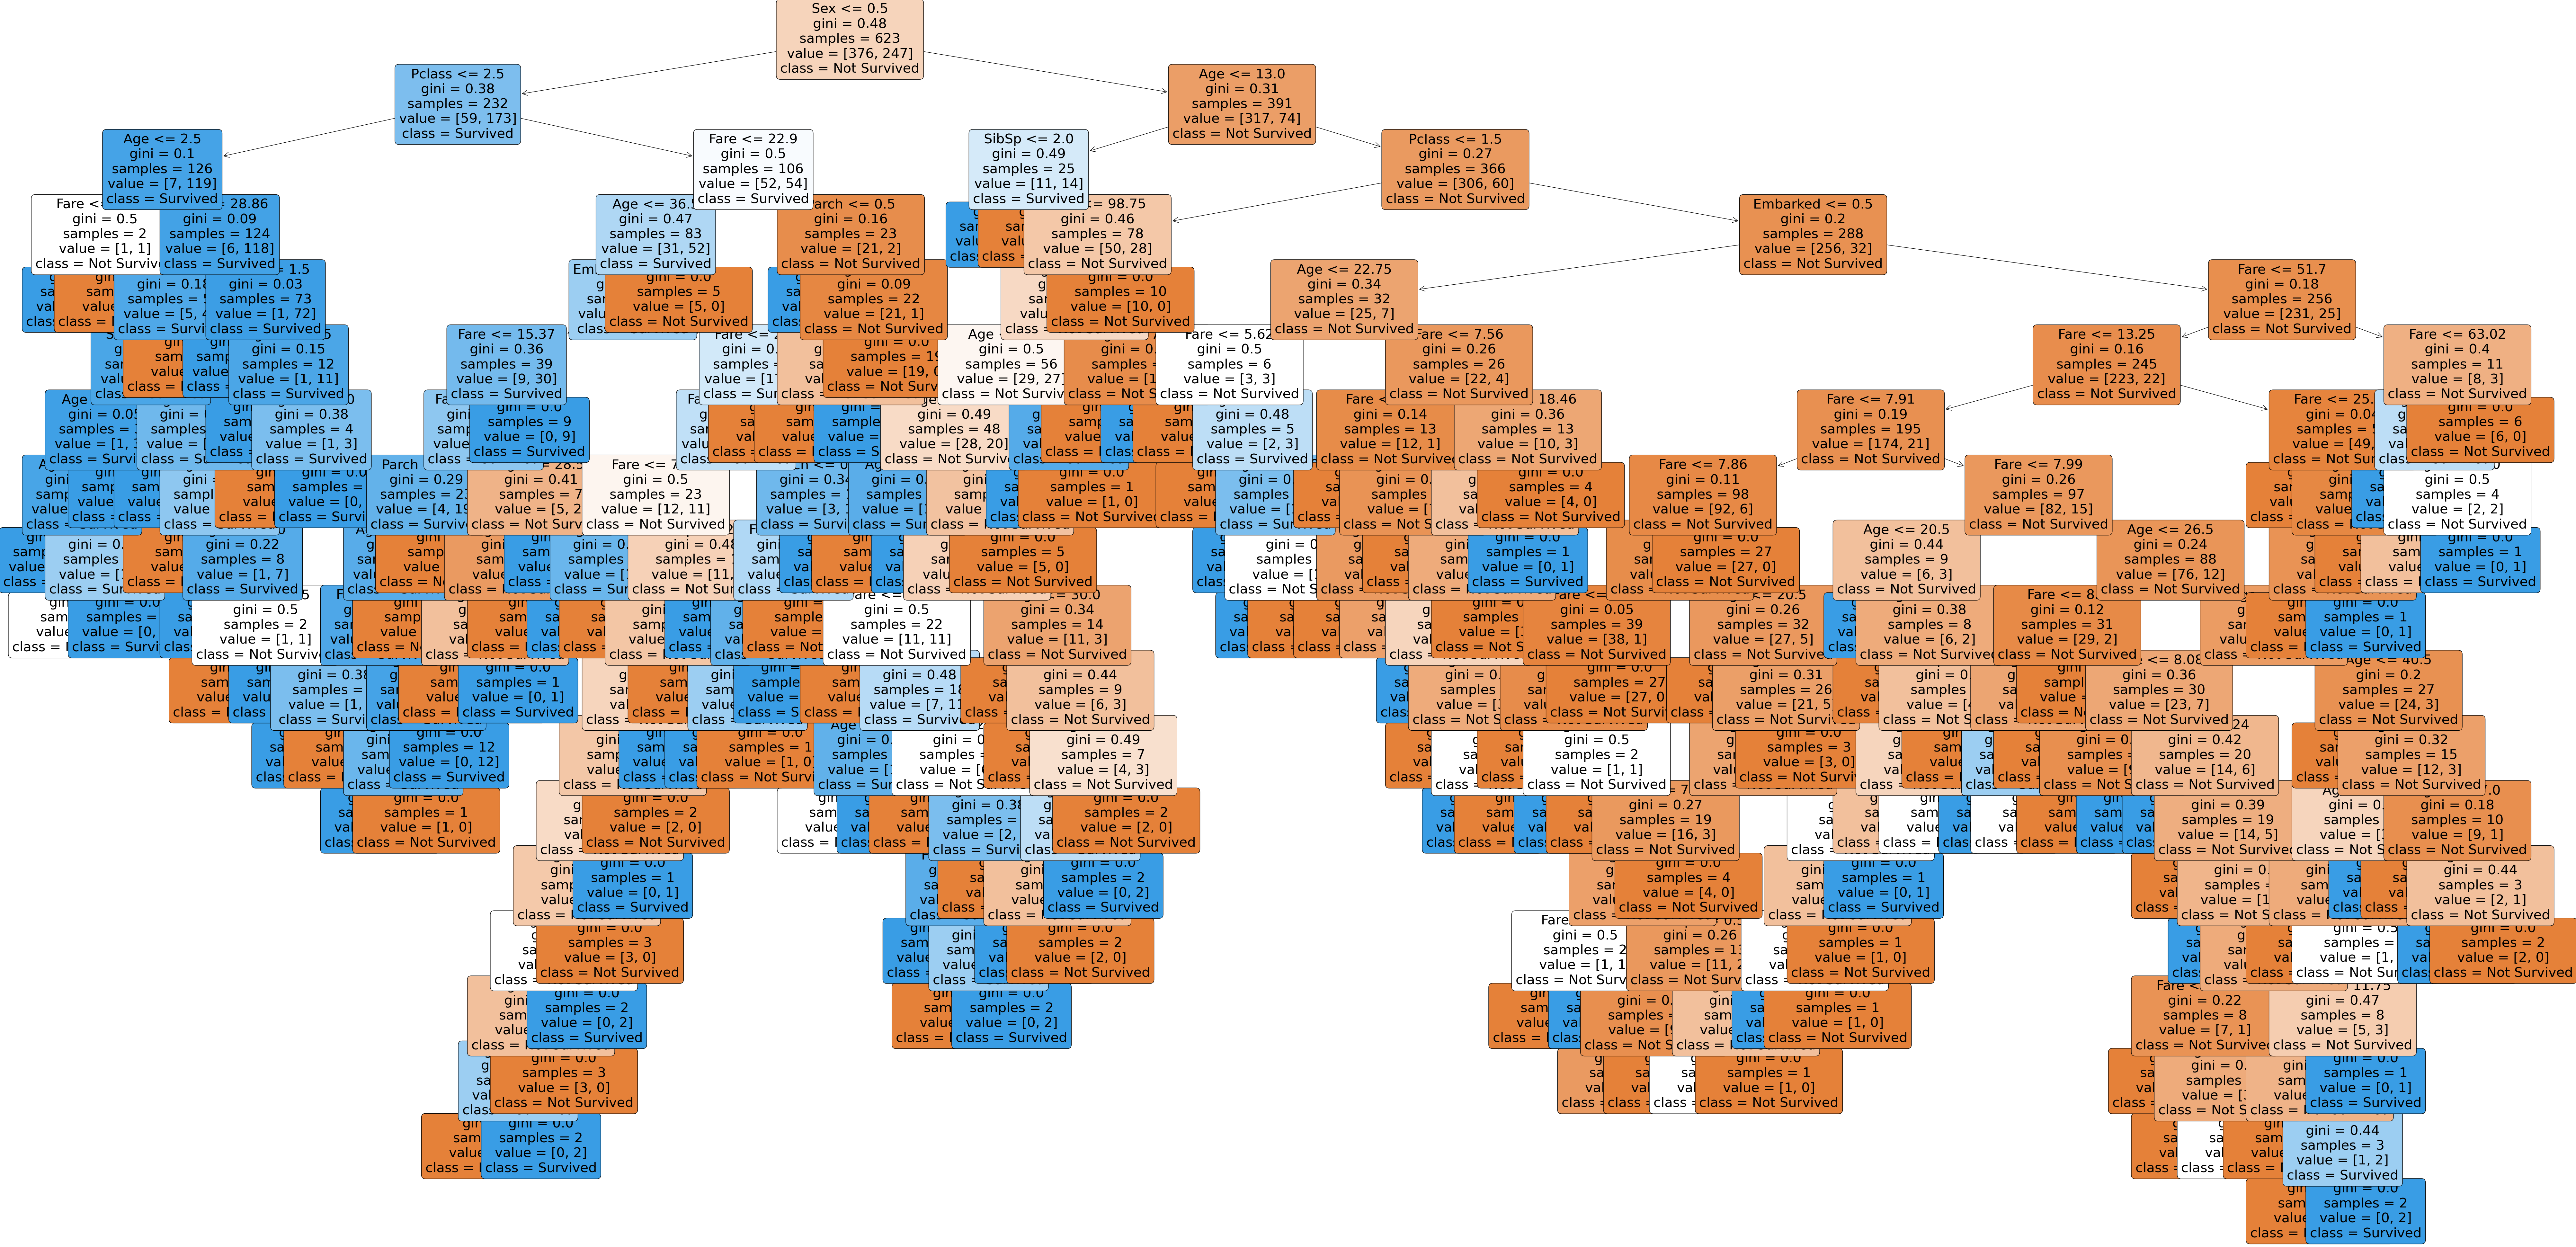

In [377]:
# Plot the tree
figure = plt.figure(figsize=(100,50))
plot_tree(tianic_model_unsimple, 
               feature_names=X_features.columns,
               class_names=["Not Survived", "Survived"],
               rounded=True, 
               proportion=False, 
               precision=2, 
               filled=True,
               fontsize=30) 
plt.show()

### Compute the model’s accuracy on the development set.

In [378]:
# Model Accuracy 
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Development Accuracy without pruning: {accuracy_score(y_dev, y_dev_pred)}")

Train Accuracy: 0.9823434991974318
Development Accuracy without pruning: 0.7985074626865671


### Try building models with different values of max_depth (2–10). 
At each step, create a plot of the tree and store the accuracies on both the training and development data.

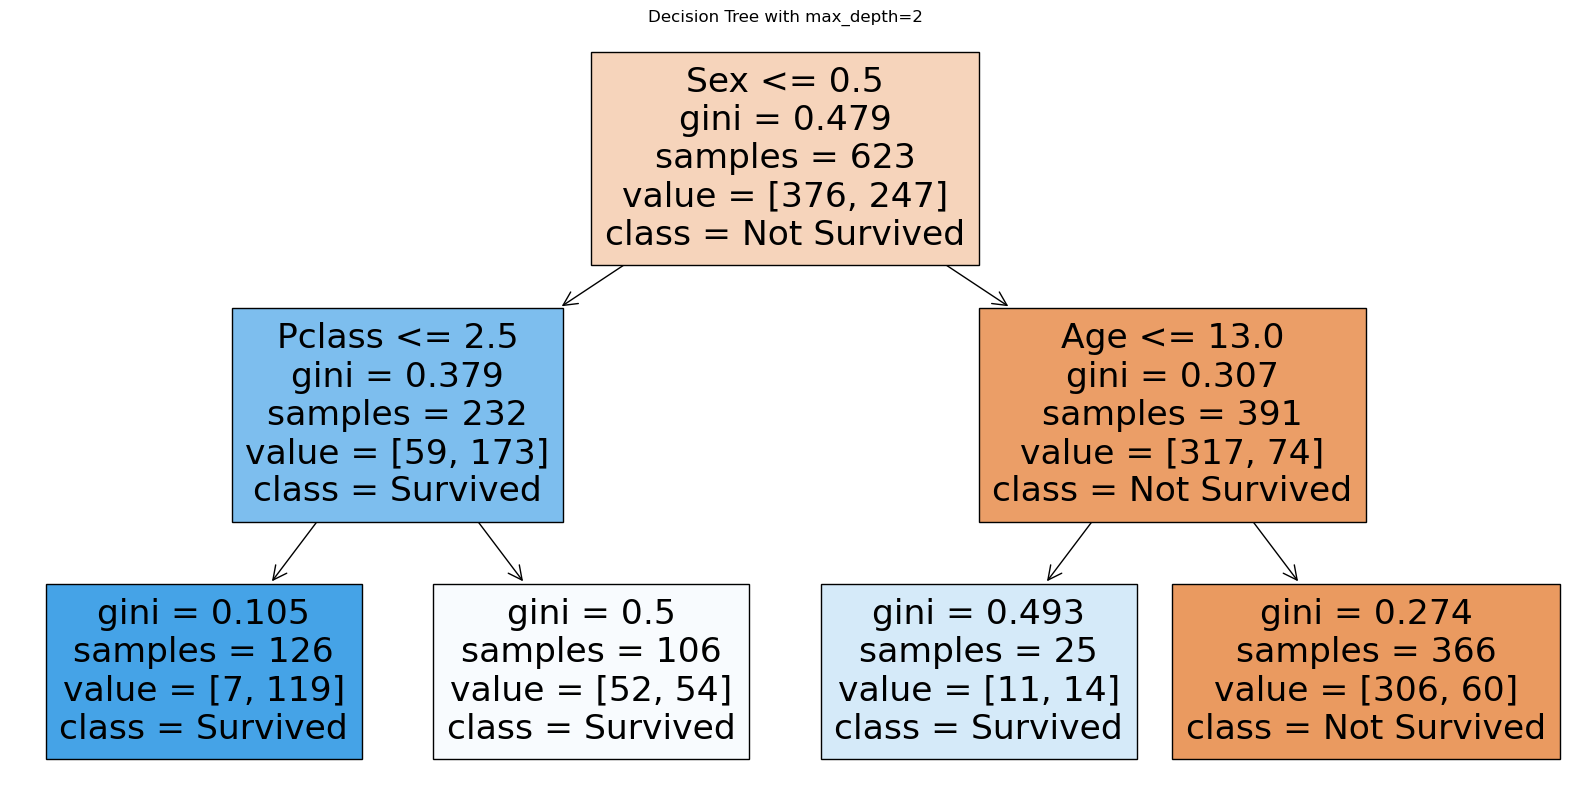

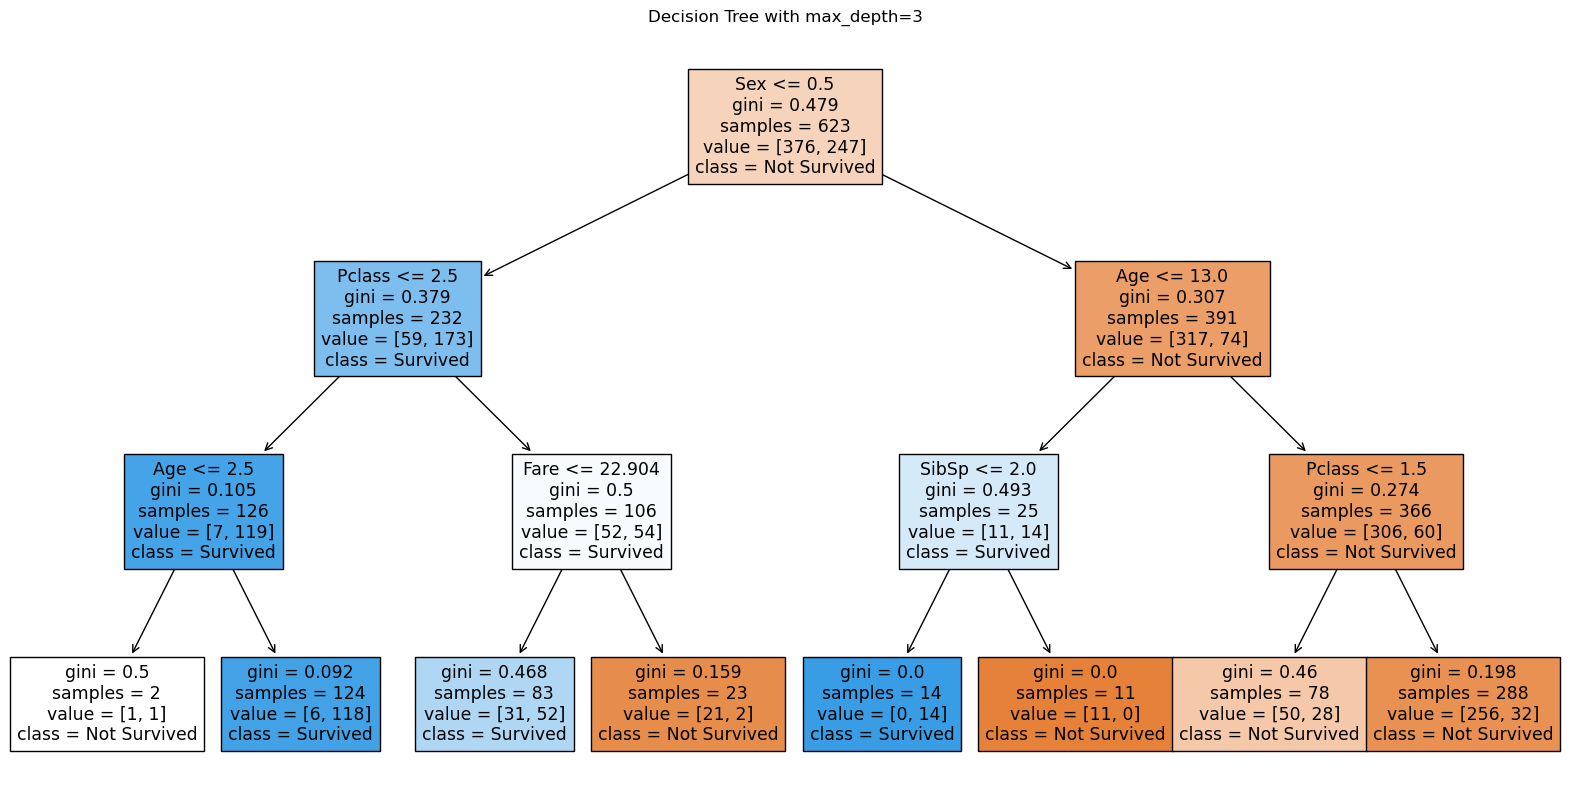

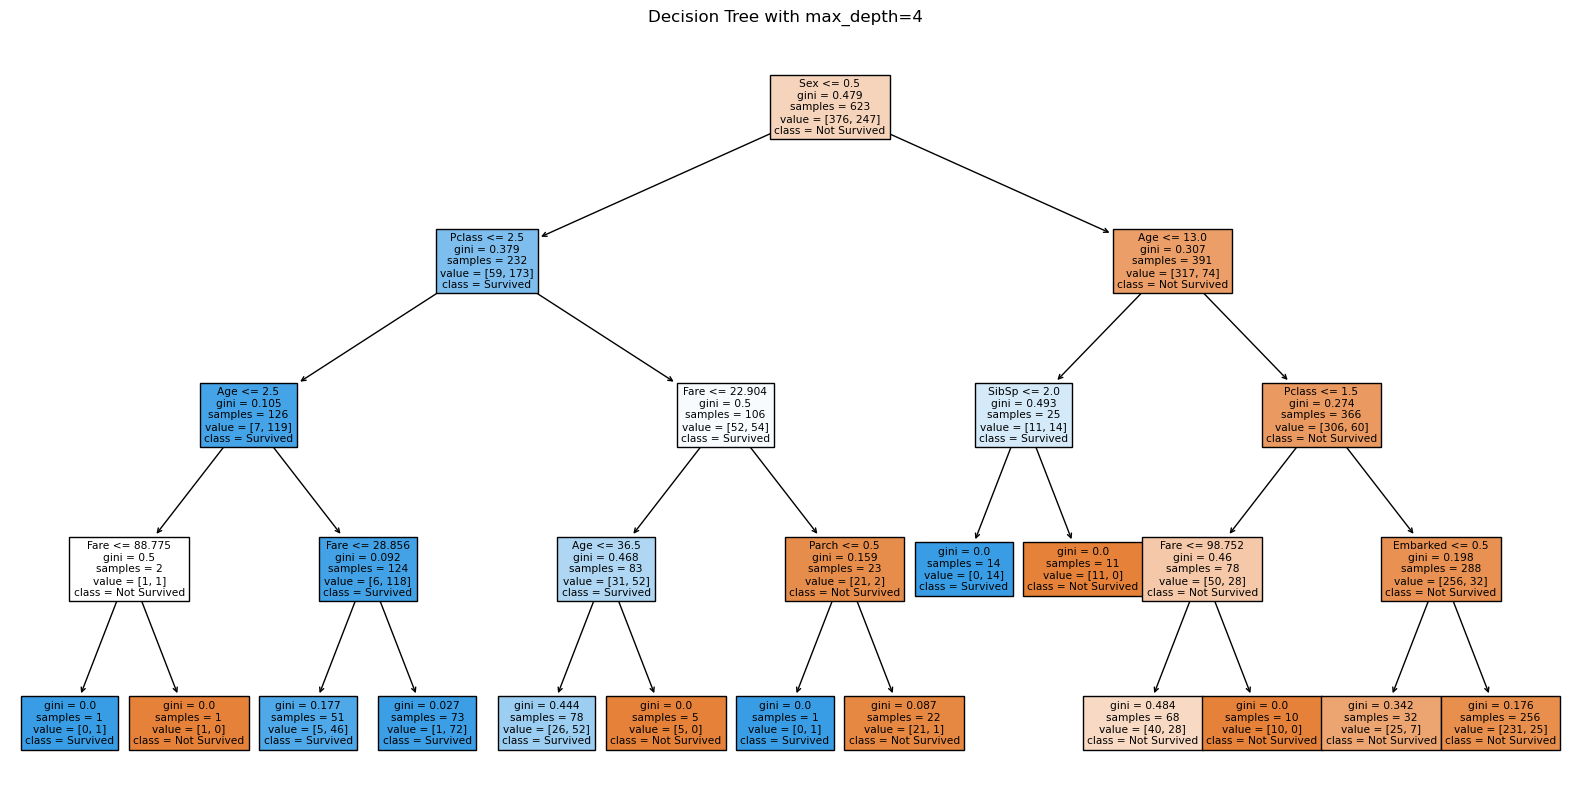

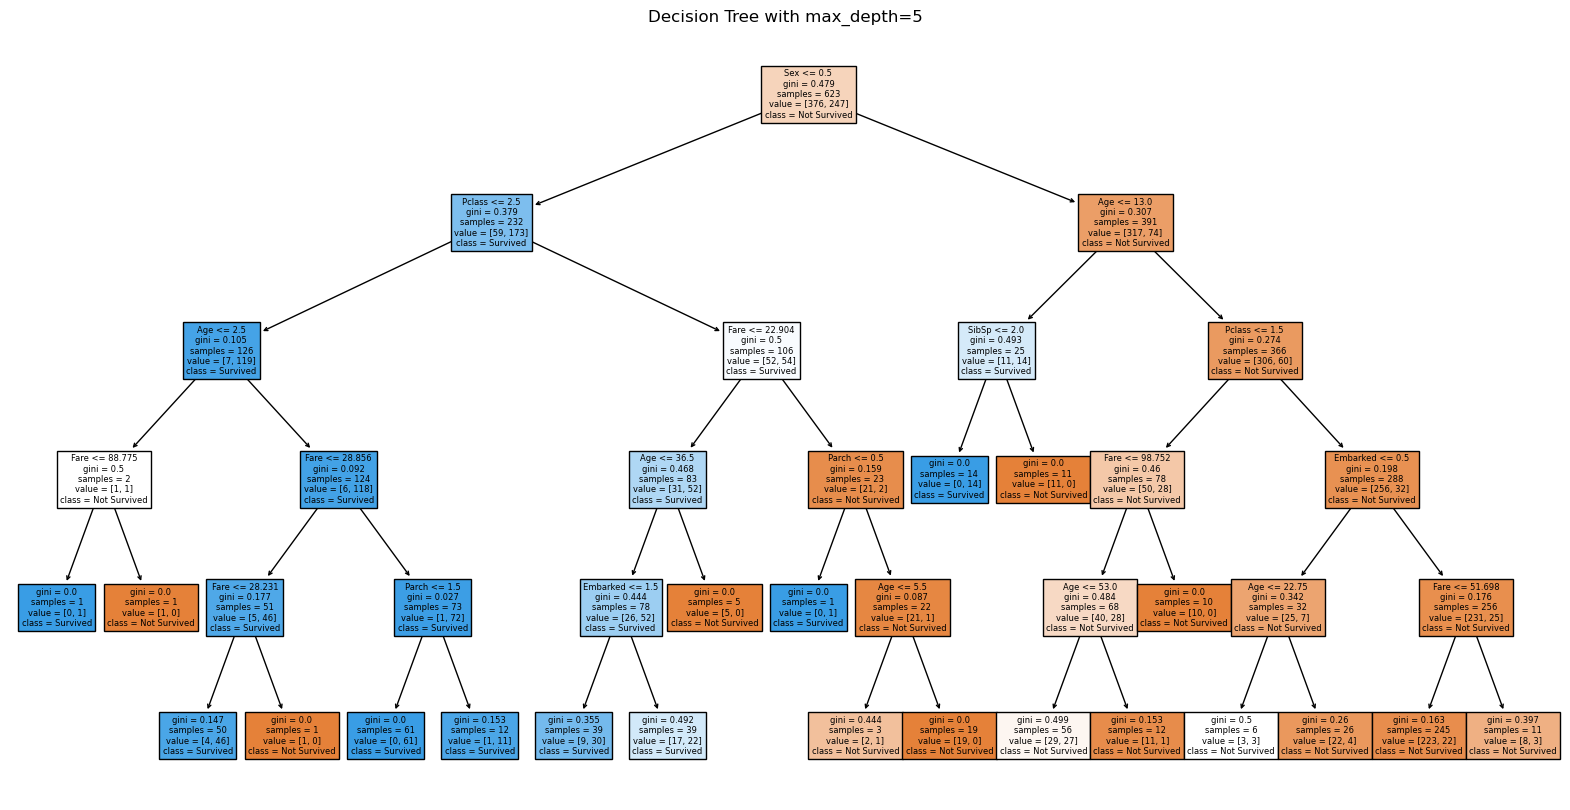

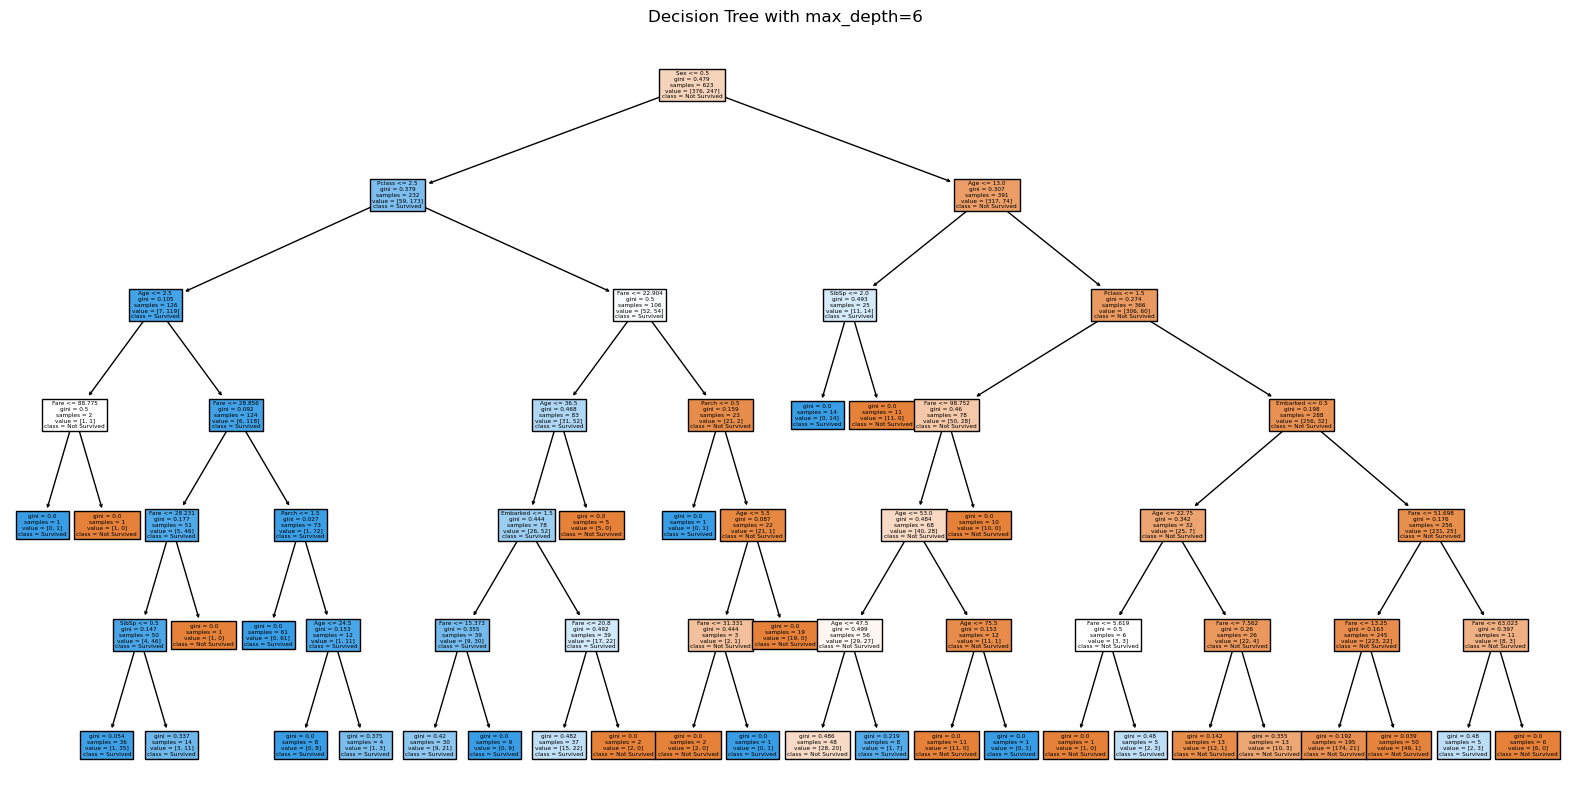

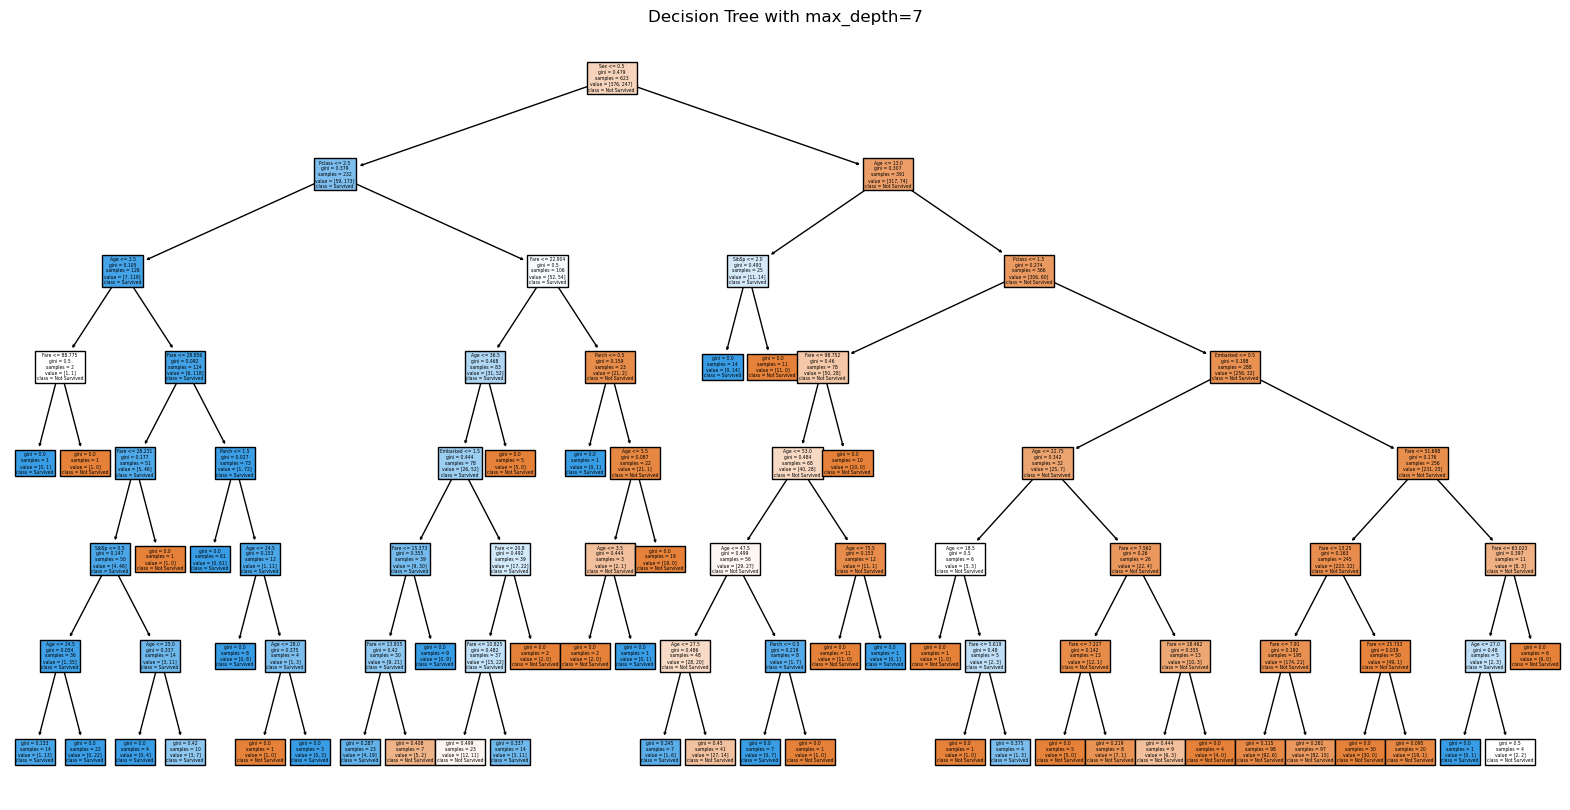

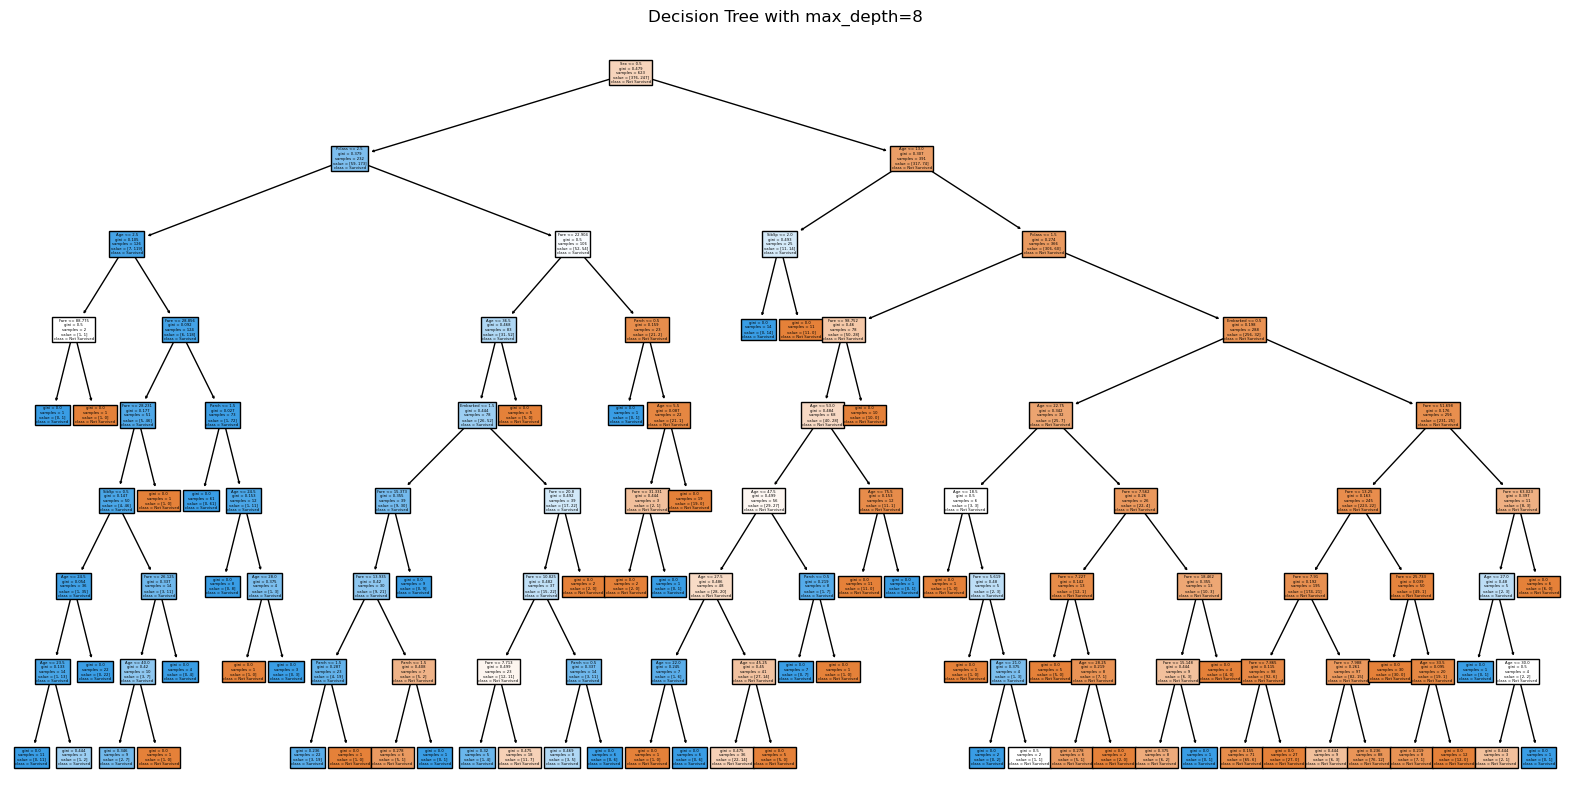

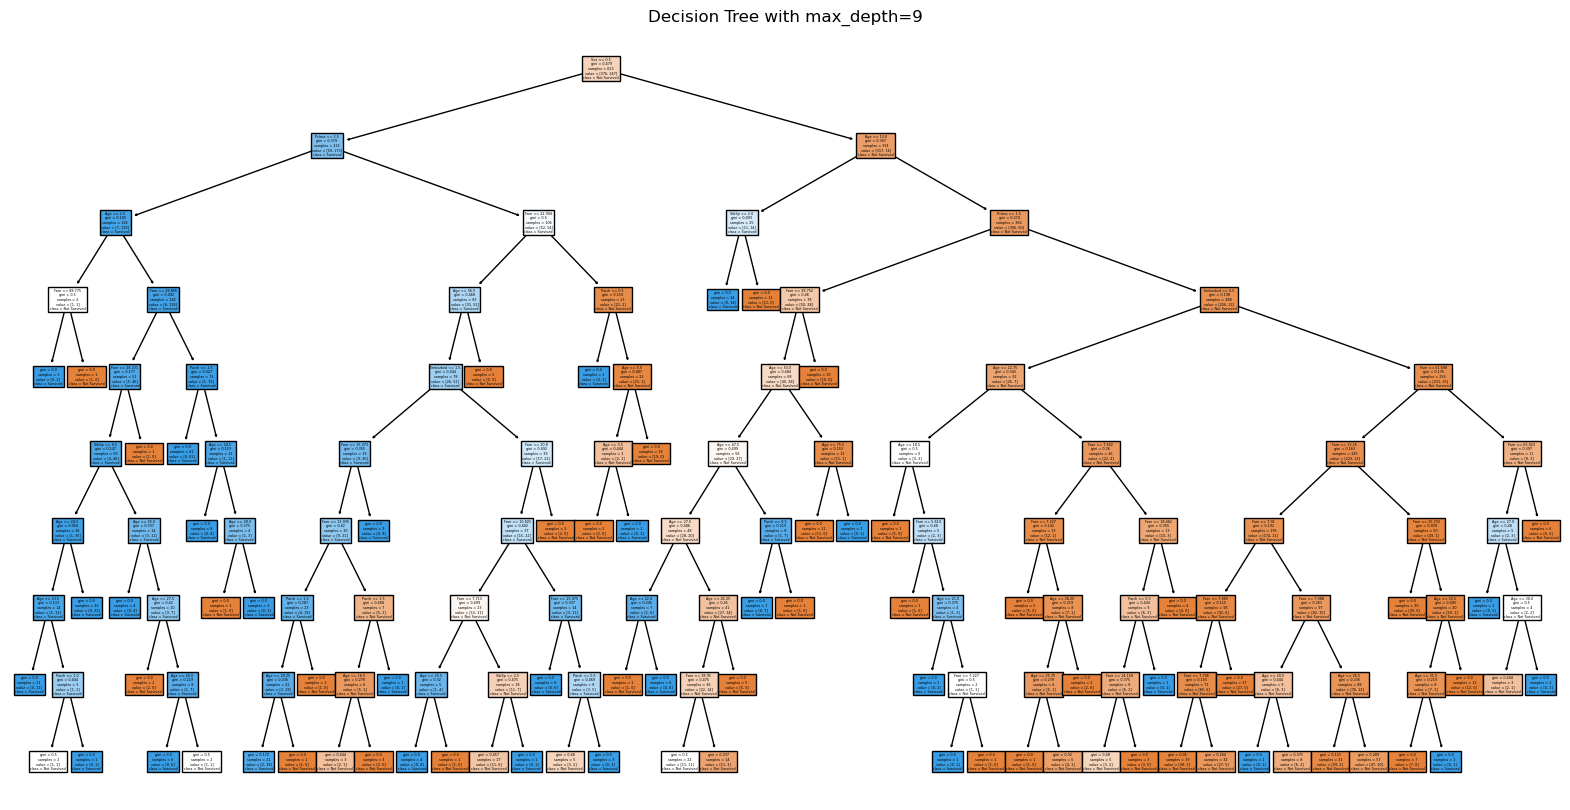

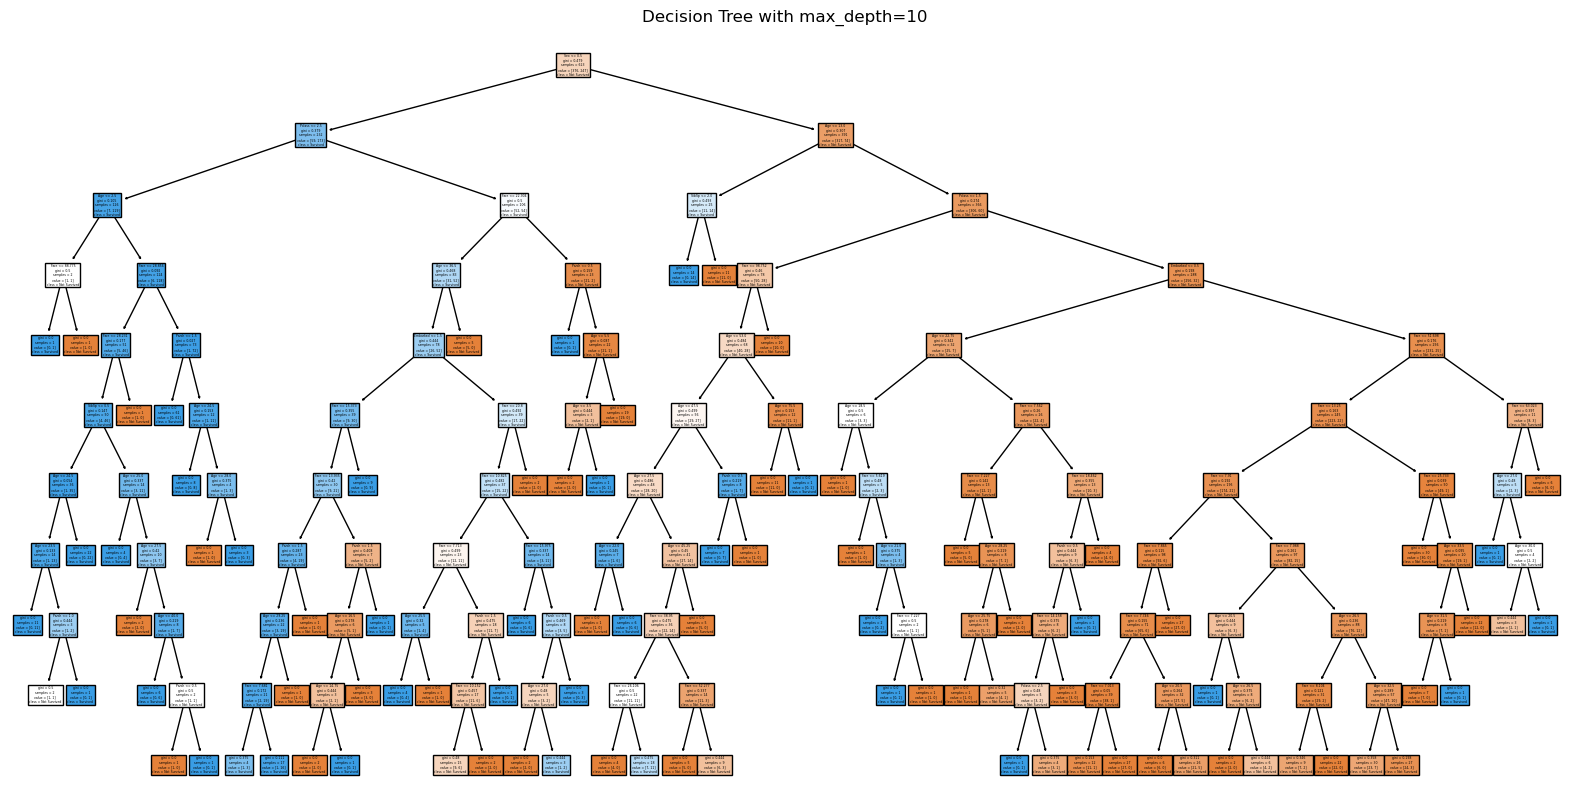

In [379]:
# train and development accuracies
train_accuracies = []
dev_accuracies = []

# Trees with different values of max_depth
max_depth_values = range(2, 11)
for depth in max_depth_values:
  # Fit the model
  tianic_model_simpler = DecisionTreeClassifier(max_depth=depth, random_state=rseed)
  tianic_model_simpler.fit(X_train, y_train)

  # Predict train and development data
  y_train_pred = tianic_model_simpler.predict(X_train)
  y_dev_pred = tianic_model_simpler.predict(X_dev)
    
  # Creat a plot of the tree
  plt.figure(figsize=(20, 10))
  plot_tree(tianic_model_simpler, 
                 feature_names=X_features.columns, 
                 class_names=["Not Survived", "Survived"], 
                 filled=True)
  plt.title(f"Decision Tree with max_depth={depth}")
  plt.show()
  
  # Compute accuracies
  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  dev_accuracy = accuracy_score(y_dev, y_dev_pred)
  dev_accuracies.append(dev_accuracy)

### Plot a line of training accuracies and another line of development accuracies in the same graph. 

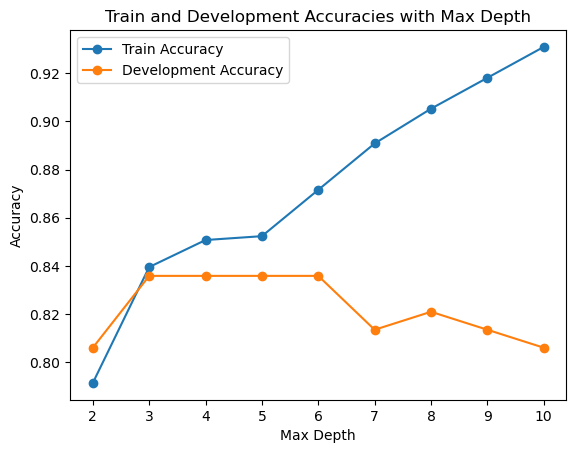

In [380]:
# Plot train and development accuracies lines
plt.plot(max_depth_values, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(max_depth_values, dev_accuracies, label="Development Accuracy", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Train and Development Accuracies with Max Depth")
plt.legend()
plt.show()

We can find that max depth after 3, although train Accuracy continues to increase, development accuracy does not grow up. Furthermore after 6, development accuracy starts to decline.

### Report the accuracy of the final model on the test data.

Best performance reached at depth of: 3


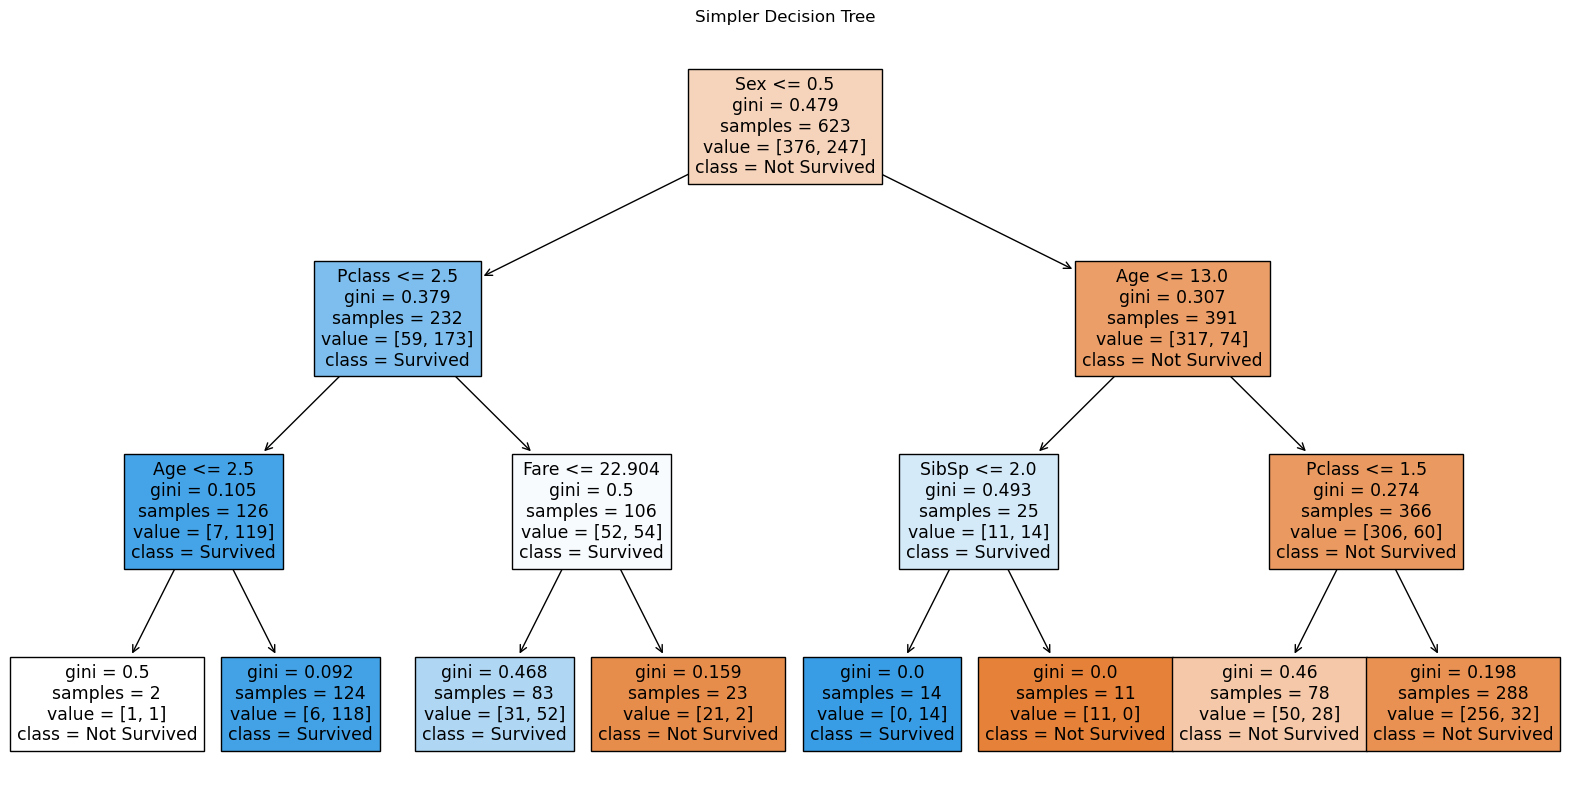

In [381]:
# Fitting the chosen tree
best_depth = max_depth_values[np.argmax(dev_accuracies)]
print("Best performance reached at depth of:", best_depth)

# Fit the model
tianic_model_simpler = DecisionTreeClassifier(max_depth=best_depth, random_state=rseed)
tianic_model_simpler.fit(X_train, y_train)

# Predict test data
y_train_pred = tianic_model_simpler.predict(X_train)
y_dev_pred = tianic_model_simpler.predict(X_dev)
y_test_pred = tianic_model_simpler.predict(X_test)

# Creat a plot of the tree
plt.figure(figsize=(20, 10))
plot_tree(tianic_model_simpler, 
                feature_names=X_features.columns, 
                class_names=["Not Survived", "Survived"], 
                filled=True)
plt.title(f"Simpler Decision Tree")
plt.show()

Train Accuracy: 0.8394863563402889
Development Accuracy: 0.835820895522388
Test Accuracy: 0.7835820895522388


Text(0.5, 1.0, 'Test Confusion Matrix')

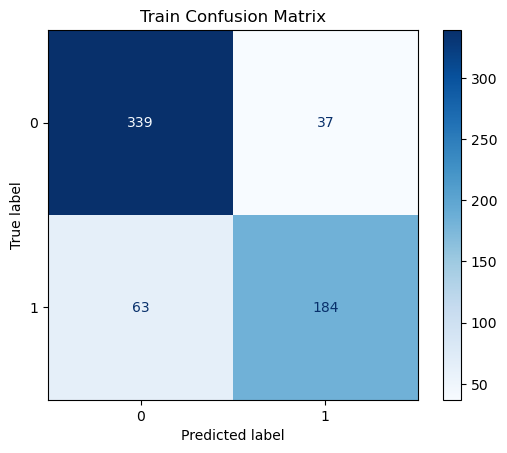

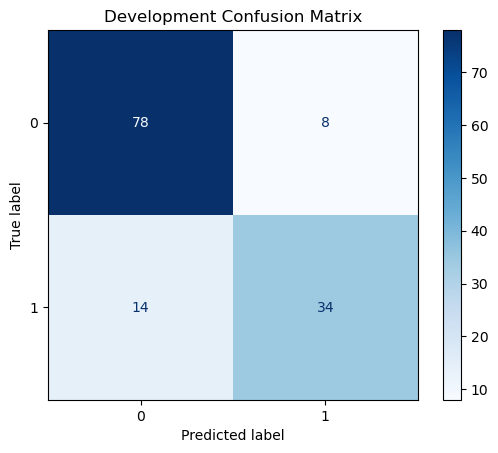

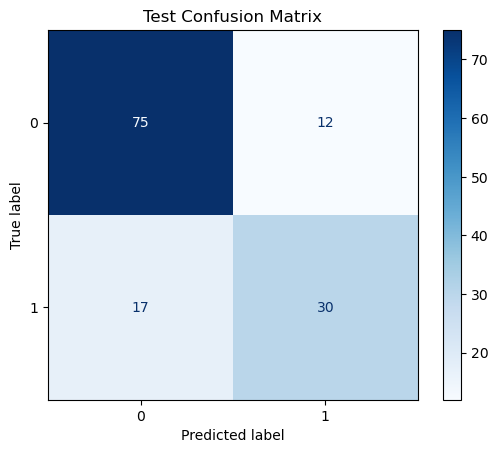

In [382]:
#Model Accuracy 
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Development Accuracy: {accuracy_score(y_dev, y_dev_pred)}")
descision_tree_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {descision_tree_accuracy}")

# Train Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred, labels=tianic_model_simpler.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=tianic_model_simpler.classes_)
disp.plot(cmap="Blues")
plt.title("Train Confusion Matrix")

# Develoment Confusion Matrix
cm_dev = confusion_matrix(y_dev, y_dev_pred, labels=tianic_model_simpler.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dev, display_labels=tianic_model_simpler.classes_)
disp.plot(cmap="Blues")
plt.title("Development Confusion Matrix")

# Test Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=tianic_model_simpler.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=tianic_model_simpler.classes_)
disp.plot(cmap="Blues")
plt.title("Test Confusion Matrix")

In [383]:
# Report scores
print(classification_report(y_test, y_test_pred, target_names=["Not Survived", "Survived"]))

              precision    recall  f1-score   support

Not Survived       0.82      0.86      0.84        87
    Survived       0.71      0.64      0.67        47

    accuracy                           0.78       134
   macro avg       0.76      0.75      0.76       134
weighted avg       0.78      0.78      0.78       134



# Random Forests Practical Task

### Split the data into a training and test.
No need development set as there is always 30% of data which is not seen by the decision tree

In [384]:
# split the dataset into train and test set. 70 : 30
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=rseed)

# Print train, devlopment, test data shapes
print("Train data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Train data: (623, 7) (623,)
Test data: (268, 7) (268,)


### Create a bagged, random forest, and boosted tree for the Titanic data set

In [385]:
# Create a bagging Classifier
base = DecisionTreeClassifier(max_depth=3)
tianic_model_bagged = BaggingClassifier(estimator=base, n_estimators=100, random_state=rseed)
tianic_model_bagged.fit(X_train,y_train)
y_bagged_pred = tianic_model_bagged.predict(X_test)

# Show accuracy score 
print("Accuracy bagged: ", tianic_model_bagged.score(X_test, y_test))

Accuracy bagged:  0.8134328358208955


In [386]:
# Create a Random Forest classifier
tianic_model_rf = RandomForestClassifier(n_estimators=100, random_state=rseed)
tianic_model_rf.fit(X_train, y_train)
y_rf_pred = tianic_model_rf.predict(X_test)

# Show accuracy score 
print("Accuracy random forest: ", tianic_model_rf.score(X_test, y_test))

Accuracy random forest:  0.8097014925373134


In [387]:
# Create a Boosted classifier
tianic_model_boost = AdaBoostClassifier(n_estimators=100, random_state=rseed)
tianic_model_boost.fit(X_train, y_train)
y_boost_pred = tianic_model_boost.predict(X_test)

# Show accuracy score 
print("Accuracy Boosted: ", tianic_model_boost.score(X_test, y_test))

Accuracy Boosted:  0.7686567164179104


### From the random forest model, determine which of the features is the one that contributes the most to predicting whether a passenger survives or not.

In [388]:
#Finding the important features by Gini importance
importances = tianic_model_rf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X_features.columns, "Gini Importance": importances}).sort_values("Gini Importance", ascending=False)
feature_importance_df

Feature  Gini Importance
5      Fare         0.264565
1       Sex         0.253821
2       Age         0.247743
0    Pclass         0.091643
3     SibSp         0.052415
6  Embarked         0.046270
4     Parch         0.043543

Text(0, 0.5, 'Features')

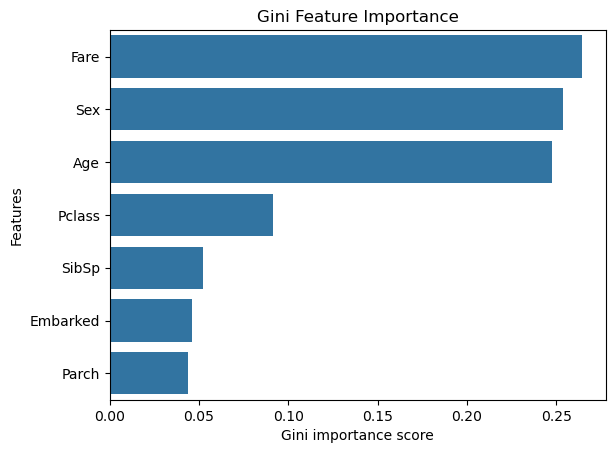

In [389]:
# Creating a seaborn bar plot
sns.barplot(x=feature_importance_df["Gini Importance"], y=feature_importance_df["Feature"], data=feature_importance_df)
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")

So "Fare" is the one that contributes the most to predicting whether a passenger survives or not.

### Pick one of these methods, and tune the parameters n_estimators and max_depth.

In [390]:
# Hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
tianic_model_rf = RandomForestClassifier(random_state=rseed)
params = {
    "max_depth": [2,3,5,10,18],
    "n_estimators": [10,25,30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=tianic_model_rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=1, 
                           scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 18],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [391]:
#Check best score hyperparameters
print("Score best random forest: ", grid_search.best_score_)
best_params = grid_search.best_params_
tianic_model_rf_best = grid_search.best_estimator_
y_rf_best_pred = tianic_model_rf_best.predict(X_test)
tianic_model_rf_best

Score best random forest:  0.8298800661703888


RandomForestClassifier(max_depth=10, n_estimators=30, random_state=23)

### Report the accuracy of all models and report which model performed the best, including the values for n_estimators and max_depth that the best model had.

In [392]:
# Accuracy of all models
accuracy_bagged = accuracy_score(y_test, y_bagged_pred)
accuracy_rf = accuracy_score(y_test, y_rf_pred)
accuracy_boost = accuracy_score(y_test, y_boost_pred)
accuracy_best_rf = accuracy_score(y_test, y_rf_best_pred)
print("Accuracy decision tree with pruning: ", descision_tree_accuracy)
print("Accuracy bagged: ", accuracy_bagged)
print("Accuracy random forest: ", accuracy_rf)
print("Accuracy Boosted: ", accuracy_boost)
print("Accuracy best random forest: ", accuracy_best_rf)

# Show the best performance model
print("After hyperparameter tuning, the best Random Forest model parameters: \n", best_params)


Accuracy decision tree with pruning:  0.7835820895522388
Accuracy bagged:  0.8134328358208955
Accuracy random forest:  0.8097014925373134
Accuracy Boosted:  0.7686567164179104
Accuracy best random forest:  0.8246268656716418
After hyperparameter tuning, the best Random Forest model parameters: 
 {'max_depth': 10, 'n_estimators': 30}
